# Plots for the 2MDM analysis

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import glob,imp,os,shutil
from pandas import json_normalize

import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from collections import OrderedDict
import seaborn as sns
from scipy.interpolate import interp1d
from IPython.display import display, Markdown

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

/tmp/ipykernel_109053/1618832188.py:5: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import glob,imp,os,shutil


#### Create txname/process translator

In [2]:
# processDict = {'TChiWZ' : r'$\tilde{\chi}_1^\pm \, \tilde{\chi}_2^0 \to W^{(*)} Z^{(*)}\, \tilde{\chi}_1^0 \tilde{\chi}_1^0$',
#               'TChiWH' : r'$\tilde{\chi}_1^\pm \, \tilde{\chi}_2^0 \to W h\, \tilde{\chi}_1^0 \tilde{\chi}_1^0$',
#               'TChiWW' : r'$\tilde{\chi}_1^\pm \, \tilde{\chi}_1^\mp \to W W \, \tilde{\chi}_1^0 \tilde{\chi}_1^0$',
#               'TDTM1F,TDTM2F' : r'$\tilde{\chi}_1^\pm \to \pi^\pm \tilde{\chi}_1^0$, DT'}
# def convertLabel(label):
#     newlabel = label[:]
#     #Replace txnames by process
#     for txlabel,proc in processDict.items():
#         newlabel = newlabel.replace(txlabel,proc) 
#     #Remove off-shell Ws and Zs from ATLAS analyses (since they only appear in on-shell cases)
#     if 'ATLAS' in newlabel:
#         newlabel = newlabel.replace('W^{(*)} Z^{(*)}', 'W Z')
#     return newlabel

In [3]:
#Merge with SModelS DataFrame
dataDF = pd.read_pickle('../../data/2mdm_results_extra/results.pcl')
print(dataDF.columns.values.tolist()) #Print all columns names

['filename', 'mass.9000006', 'mass.9900032', 'mass.9900026', 'width.9000006', 'width.9900026', 'width.9900032', 'extpar.1', 'extpar.2', 'extpar.3', 'extpar.4', 'extpar.5', 'extpar.6', 'extpar.7', 'xsec13TeV(fb).9900032', 'xsec13TeV(fb).9900026', 'BRs.sd.W-,W+', 'BRs.sd.higgs,higgs', 'BRs.sd.Z,Z', 'BRs.sd.t-,t+', 'BRs.zp.b,b', 'BRs.zp.c,c', 'BRs.zp.q,q', 'BRs.zp.t-,t+', 'BRs.sd.chi,chi', 'BRs.zp.chi,chi', 'totalxsec13TeV(fb)', 'totalxsec8TeV(fb)', 'Total xsec for missing topologies (fb)', 'Total xsec for missing topologies with displaced decays (fb)', 'Total xsec for missing topologies with prompt decays (fb)', 'Total xsec for topologies outside the grid (fb)', 'OutputStatus.sigmacut', 'OutputStatus.minmassgap', 'OutputStatus.maxcond', 'OutputStatus.ncpus', 'OutputStatus.model', 'OutputStatus.promptwidth', 'OutputStatus.stablewidth', 'OutputStatus.eraseprompt', 'OutputStatus.checkinput', 'OutputStatus.doinvisible', 'OutputStatus.docompress', 'OutputStatus.computestatistics', 'OutputStat

#### Set r = 0 for points with no results 

In [4]:
#Set points without results with r == 0
dataDF.fillna(value={'ExptRes.result0.r' : 0.0},inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)

#### Define exclusions

In [5]:
#Add simple flag for excluded points:
dataDF['excludedLHC'] = dataDF['ExptRes.result0.r'] > 1.0

### Get points excluded:

In [6]:
excluded = dataDF[dataDF['excludedLHC'] == True]

allowed = dataDF[(dataDF['excludedLHC'] == False)]


print('Total number of points = %i' %len(dataDF))
print('Total excluded (LHC) = %i'%(len(excluded)))
print('Total allowed = %i\n'%(len(allowed)))

# print('Total excluded (r > %1.2f) = %i'%(rscale,len(excludedSC)))
# print('Total allowed (r > %1.2f) = %i'%(rscale,len(allowedSC)))


Total number of points = 1000
Total excluded (LHC) = 888
Total allowed = 112



### Create analysis label for excluded points

In [7]:
anas = excluded['ExptRes.result0.AnalysisID'].value_counts()
anas.sort_values(inplace=True,ascending=False)

    
labels = []
for index, row in excluded.iterrows():
    ana = row['ExptRes.result0.AnalysisID']
    txList = sorted(row['ExptRes.result0.TxNames'])
    label = ana + ' (' + ','.join(txList) + ')'
    label = label.replace('off','') #Group together on and off-shell topologies
    labels.append(label)
excluded['label'] = labels


In [8]:
nexcluded = [[len(excluded[excluded['label'] == label]),label] for label in excluded['label'].unique()]
nexcluded = sorted(nexcluded,reverse=True)
nexcluded = np.array(nexcluded)
for label in nexcluded[:,1]:
    print(label+': %i'%len(excluded[excluded['label'] == label]))

ATLAS-EXOT-2019-03 (TRV1qq): 642
CMS-PAS-EXO-20-008 (TRV1bb): 150
CMS-EXO-19-012 (TRV1qq): 82
ATLAS-EXOT-2019-03 (TRV1bb): 14


### Define colors and plotting order

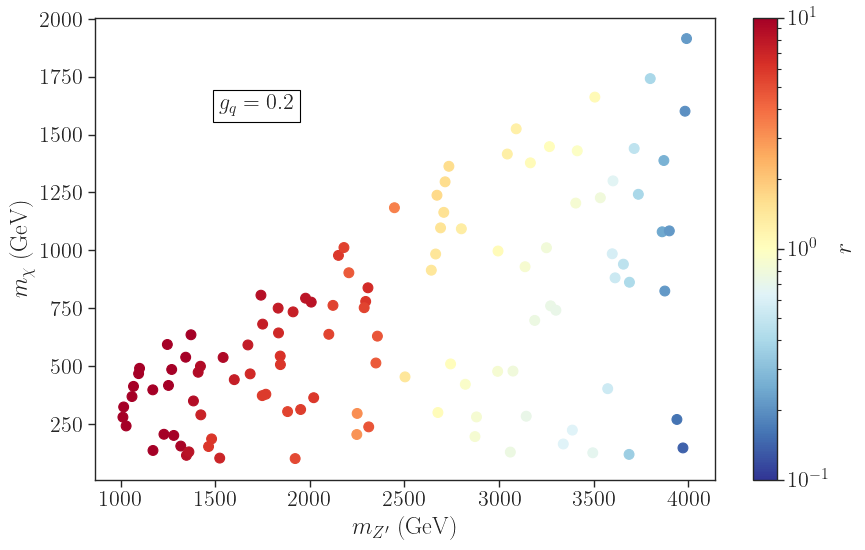

In [26]:
cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=(10,6))
# Select points 
gqv = 0.2
x = dataDF['mass.9900032'][dataDF['extpar.2']==gqv]
y = dataDF['mass.9000006'][dataDF['extpar.2']==gqv]
c = dataDF['ExptRes.result0.r'][dataDF['extpar.2']==gqv]
# x = x[c.argsort()]
# y = y[c.argsort()]
# c = c[c.argsort()]

plt.scatter(x,y,c=c,s=50,cmap=cm, norm=LogNorm(vmin=1e-1,vmax=1e1))
# # plt.plot([x.min(),x.max()],[x.min(),x.max()],'--')
plt.colorbar(label=r'$r$')
plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.ylabel(r'$m_{\chi}$ (GeV)')
plt.text(0.2,0.8,r"$g_{q} = %1.1f$" %gqv,fontsize=16,bbox=dict(facecolor='white', edgecolor='black'),
         transform = plt.gca().transAxes)

# plt.tight_layout()
# plt.savefig('charginoLifetime.png')
plt.show()

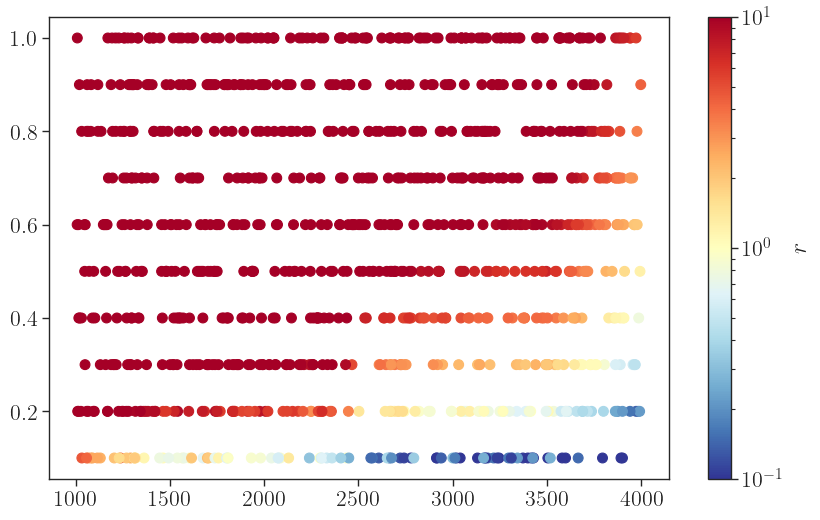

In [11]:
cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=(10,6))
# Select points 
gqv = 0.2
x = dataDF['mass.9900032']
y = dataDF['extpar.2']
c = dataDF['ExptRes.result0.r']
x = x[c.argsort()]
y = y[c.argsort()]
c = c[c.argsort()]

plt.scatter(x,y,c=c,s=50,cmap=cm, norm=LogNorm(vmin=1e-1,vmax=1e1))
# # plt.plot([x.min(),x.max()],[x.min(),x.max()],'--')
plt.colorbar(label=r'$r$')
plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.ylabel(r'$M_2/M_1$ (GeV)')

# plt.tight_layout()
# plt.savefig('charginoLifetime.png')
plt.show()

### Neutralino Branching ratio

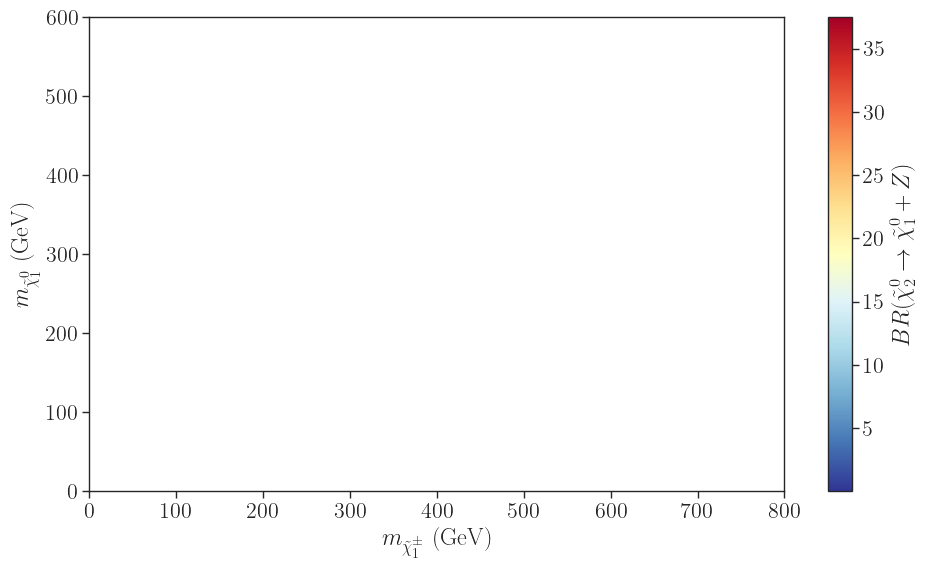

In [12]:
deleteCurves = ['CMS-PAS-EXO-20-008']
anas = excluded['label'].value_counts()
anas.sort_values(inplace=True,ascending=False)

plt.figure(figsize=(10,6))

cm = plt.cm.get_cmap('RdYlBu_r')
x = dataDF['mass.9900032']
y = dataDF['mass.9000006']
c = dataDF['']
for ana in anas.index:
    if not ana in excCurves: continue
    if any(val in ana for val in deleteCurves): continue
    curve = excCurves[ana]
    color = colorDict[ana]
    plt.plot(curve[:,0],curve[:,1],linewidth=3,linestyle='-',color=color)

plt.scatter(x,y,c=c,s=50,cmap=cm)
# plt.plot([x.min(),x.max()],[x.min(),x.max()],'--')
plt.colorbar(label=r'$BR(\tilde \chi_2^0 \to \tilde \chi_1^0 +Z)$')
plt.xlabel(r'$m_{\tilde{\chi}_1^\pm}$ (GeV)')
plt.ylabel(r'$m_{\tilde{\chi}_1^0}$ (GeV)')
plt.ylim(0,600)
plt.xlim(0,800)
plt.tight_layout()
plt.show()

In [10]:
anas

ATLAS-EXOT-2019-03    543
CMS-EXO-19-012        118
CMS-PAS-EXO-20-008     70
Name: ExptRes.result0.AnalysisID, dtype: int64

In [13]:
dataDF['extpar.4'].T

524    0.0
493    0.0
254    0.0
992    0.0
145    0.0
      ... 
504    0.0
901    0.0
55     0.0
923    0.0
937    0.0
Name: extpar.4, Length: 1000, dtype: float64

In [20]:
for file in dataDF['filename']:
    print(file)

run_598_zp_1009_dm_340_gqv_010.slha
run_258_zp_1020_dm_337_gqv_09.slha
run_994_zp_1061_dm_383_gqv_09.slha
run_824_zp_1082_dm_205_gqv_09.slha
run_48_zp_1032_dm_488_gqv_08.slha
run_866_zp_1171_dm_286_gqv_010.slha
run_247_zp_1059_dm_450_gqv_08.slha
run_477_zp_1118_dm_170_gqv_09.slha
run_397_zp_1067_dm_526_gqv_08.slha
run_595_zp_1080_dm_438_gqv_08.slha
run_155_zp_1193_dm_112_gqv_010.slha
run_710_zp_1212_dm_175_gqv_010.slha
run_391_zp_1229_dm_503_gqv_010.slha
run_216_zp_1118_dm_474_gqv_08.slha
run_278_zp_1188_dm_268_gqv_09.slha
run_932_zp_1257_dm_286_gqv_010.slha
run_751_zp_1259_dm_246_gqv_010.slha
run_868_zp_1135_dm_208_gqv_08.slha
run_263_zp_1277_dm_187_gqv_010.slha
run_579_zp_1015_dm_443_gqv_06.slha
run_609_zp_1008_dm_106_gqv_06.slha
run_897_zp_1237_dm_321_gqv_09.slha
run_936_zp_1296_dm_138_gqv_010.slha
run_928_zp_1051_dm_475_gqv_06.slha
run_564_zp_1046_dm_363_gqv_06.slha
run_766_zp_1196_dm_147_gqv_08.slha
run_426_zp_1331_dm_434_gqv_010.slha
run_350_zp_1331_dm_342_gqv_010.slha
run_513_zp